# NB03: Metal Utilization Phenotypes (Exploratory)

Cross-reference BacDive's 98 metal utilization test records with metal tolerance scores.
Small sample sizes — treat as exploratory.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import stats

PROJ = os.path.abspath('..')
MAIN_REPO = '/home/psdehal/pangenome_science/BERIL-research-observatory'
BACDIVE = os.path.join(MAIN_REPO, 'data', 'bacdive_ingest')
DATA_OUT = os.path.join(PROJ, 'data')
FIG_OUT = os.path.join(PROJ, 'figures')

In [2]:
# Load bridge from NB01
bridge = pd.read_csv(os.path.join(DATA_OUT, 'matched_strains.csv'))
print(f'Matched strains: {len(bridge)}')

# Load metabolite utilization
met = pd.read_csv(os.path.join(BACDIVE, 'metabolite_utilization.tsv'), sep='\t')

# Filter to metal compounds
metal_keywords = 'iron|manganese|arsenate|chromat|molybd|cobalt|zinc|copper|nickel|mercury|cadmium|tungst|selenium|uranium'
metal_met = met[met['compound_name'].str.contains(metal_keywords, case=False, na=False)].copy()
print(f'Metal utilization records: {len(metal_met)}')
print(f'Unique compounds: {metal_met["compound_name"].nunique()}')
print(f'Unique strains: {metal_met["bacdive_id"].nunique()}')
print(f'\nCompound × result counts:')
print(metal_met.groupby(['compound_name', 'utilization']).size().unstack(fill_value=0).to_string())

Matched strains: 42227


Metal utilization records: 98
Unique compounds: 11
Unique strains: 69

Compound × result counts:
utilization                  +   -
compound_name                     
amorphous iron (iii) oxide   1   5
arsenate                     7   2
chromate                     0   3
cobalt dichloride            0   1
ferric iron                 12  16
iron                         5  13
iron trichloride             1   3
manganese                    5  13
manganese dioxide            3   4
molybdate                    0   3
zinc dichloride              0   1


In [3]:
# Join metal utilization with bridge (metal scores)
metal_met_scores = metal_met.merge(bridge[['bacdive_id', 'metal_score_norm', 'metal_score_raw', 
                                            'bacdive_species', 'bacdive_genus', 'bacdive_phylum']], 
                                    on='bacdive_id', how='inner')

print(f'Metal utilization records with metal scores: {len(metal_met_scores)}')
print(f'Unique strains: {metal_met_scores["bacdive_id"].nunique()}')

if len(metal_met_scores) > 0:
    # Simplify utilization to positive/negative
    metal_met_scores['result'] = metal_met_scores['utilization'].map({
        '+': 'positive', 'positive': 'positive',
        '-': 'negative', 'negative': 'negative',
        'produced': 'positive', 'variable': 'variable',
        'weak': 'positive',
    }).fillna('other')
    
    print(f'\nSimplified results:')
    print(metal_met_scores['result'].value_counts().to_string())

Metal utilization records with metal scores: 24
Unique strains: 17

Simplified results:
result
negative    16
positive     8


In [4]:
# Compare metal scores: positive vs negative metal utilization
if len(metal_met_scores) > 0:
    pos = metal_met_scores[metal_met_scores.result == 'positive']['metal_score_norm']
    neg = metal_met_scores[metal_met_scores.result == 'negative']['metal_score_norm']
    
    print(f'Positive metal utilization: n={len(pos)}, median={pos.median():.4f}, mean={pos.mean():.4f}')
    print(f'Negative metal utilization: n={len(neg)}, median={neg.median():.4f}, mean={neg.mean():.4f}')
    
    if len(pos) >= 3 and len(neg) >= 3:
        u, p = stats.mannwhitneyu(pos, neg, alternative='two-sided')
        print(f'\nMann-Whitney U: U={u:.0f}, p={p:.3f}')
        
        pooled_std = np.sqrt((pos.std()**2 + neg.std()**2) / 2)
        d = (pos.mean() - neg.mean()) / pooled_std if pooled_std > 0 else 0
        print(f'Cohen\'s d: {d:+.3f}')
    
    # Per-compound breakdown
    print(f'\n=== Per-compound comparison ===')
    for compound in sorted(metal_met_scores['compound_name'].unique()):
        csub = metal_met_scores[metal_met_scores.compound_name == compound]
        cpos = csub[csub.result == 'positive']['metal_score_norm']
        cneg = csub[csub.result == 'negative']['metal_score_norm']
        if len(cpos) > 0 or len(cneg) > 0:
            pos_med = f'{cpos.median():.4f}' if len(cpos) > 0 else 'n/a'
            neg_med = f'{cneg.median():.4f}' if len(cneg) > 0 else 'n/a'
            print(f'  {compound:30s}: pos n={len(cpos)} (med={pos_med}), neg n={len(cneg)} (med={neg_med})')
else:
    print('No metal utilization records matched to metal scores')

Positive metal utilization: n=8, median=0.2401, mean=0.2571
Negative metal utilization: n=16, median=0.3008, mean=0.2855

Mann-Whitney U: U=40, p=0.140
Cohen's d: -0.571

=== Per-compound comparison ===
  amorphous iron (iii) oxide    : pos n=0 (med=n/a), neg n=1 (med=0.2487)
  arsenate                      : pos n=1 (med=0.3645), neg n=1 (med=0.2464)
  chromate                      : pos n=0 (med=n/a), neg n=2 (med=0.3055)
  ferric iron                   : pos n=5 (med=0.2237), neg n=3 (med=0.2464)
  iron                          : pos n=2 (med=0.2401), neg n=3 (med=0.3104)
  iron trichloride              : pos n=0 (med=n/a), neg n=2 (med=0.2808)
  manganese                     : pos n=0 (med=n/a), neg n=3 (med=0.3104)
  manganese dioxide             : pos n=0 (med=n/a), neg n=1 (med=0.2918)


/tmp/ipykernel_17897/3857736690.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([pos.values, neg.values], labels=['Positive', 'Negative'],
/tmp/ipykernel_17897/3857736690.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(compound_data, labels=compound_labels, patch_artist=True, widths=0.6)


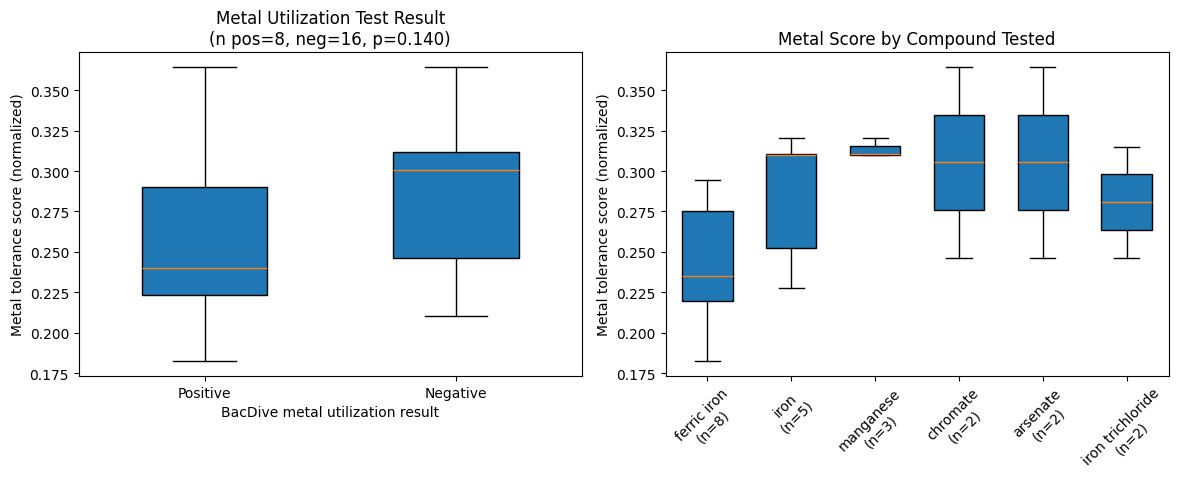

Saved: figures/utilization_vs_score.png


In [5]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

if len(metal_met_scores) > 0 and len(pos) >= 3 and len(neg) >= 3:
    # Panel 1: Positive vs negative metal utilization
    axes[0].boxplot([pos.values, neg.values], labels=['Positive', 'Negative'], 
                    patch_artist=True, widths=0.5)
    axes[0].set_ylabel('Metal tolerance score (normalized)')
    axes[0].set_title(f'Metal Utilization Test Result\n(n pos={len(pos)}, neg={len(neg)}, p={p:.3f})')
    axes[0].set_xlabel('BacDive metal utilization result')
    
    # Panel 2: Per-compound scores
    compounds = metal_met_scores['compound_name'].value_counts().head(8).index
    compound_data = []
    compound_labels = []
    for comp in compounds:
        csub = metal_met_scores[metal_met_scores.compound_name == comp]['metal_score_norm'].dropna()
        if len(csub) >= 2:
            compound_data.append(csub.values)
            compound_labels.append(f'{comp}\n(n={len(csub)})')
    
    if compound_data:
        axes[1].boxplot(compound_data, labels=compound_labels, patch_artist=True, widths=0.6)
        axes[1].set_ylabel('Metal tolerance score (normalized)')
        axes[1].set_title('Metal Score by Compound Tested')
        axes[1].tick_params(axis='x', rotation=45)
else:
    axes[0].text(0.5, 0.5, 'Insufficient data', transform=axes[0].transAxes, ha='center')
    axes[1].text(0.5, 0.5, 'Insufficient data', transform=axes[1].transAxes, ha='center')

plt.tight_layout()
plt.savefig(os.path.join(FIG_OUT, 'utilization_vs_score.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figures/utilization_vs_score.png')

In [6]:
# Save results
if len(metal_met_scores) > 0:
    metal_met_scores.to_csv(os.path.join(DATA_OUT, 'metal_utilization_validation.csv'), index=False)
    print(f'Saved: data/metal_utilization_validation.csv ({len(metal_met_scores)} records)')

print(f'\n=== Summary ===')
print(f'Metal utilization records matched to scores: {len(metal_met_scores)}')
if len(metal_met_scores) > 0 and len(pos) >= 3 and len(neg) >= 3:
    print(f'Positive vs negative: d={d:+.3f}, p={p:.3f}')
    print(f'Note: Small sample sizes — treat as exploratory')
else:
    print('Insufficient data for statistical comparison')

Saved: data/metal_utilization_validation.csv (24 records)

=== Summary ===
Metal utilization records matched to scores: 24
Positive vs negative: d=-0.571, p=0.140
Note: Small sample sizes — treat as exploratory
